# TF-IDF and SVM classification

In [53]:
# preprocessing & utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# text handling 
import nltk
import re
import spacy
import string
from nltk.corpus import stopwords

# models for classification
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [44]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Erica\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Functions

In [73]:
def plot_cm(pipeline, X_test, y_test):
    plt.figure(figsize=(15,15))
    plot_confusion_matrix(pipeline, X_test, y_test)  
    plt.xticks(rotation=45, fontsize = 10)
    plt.yticks(rotation=0, fontsize = 8)
    plt.title("Confusion matrix")
    plt.show()
    
def eval_accuracy (pred, test):
    correct = 0
    for prediction,true_label in zip(predictions, y_test):
        if prediction==true_label:
            correct += 1
    return (correct/len(predictions))

In [25]:
df = pd.read_csv("data/books_def.csv", index_col=0)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36638 entries, Suzanne Collins to Mimi Baird|Eve Claxton
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   book_desc    36638 non-null  object 
 1   book_rating  36638 non-null  float64
 2   book_title   36638 non-null  object 
 3   genres       36638 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


In [27]:
df.head()

,book_desc,book_rating,book_title,genres
book_authors,,,,
Suzanne Collins,Winning will make you famous. Losing means cer...,4.33,The Hunger Games,Young Adult
J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,4.48,Harry Potter and the Order of the Phoenix,Fantasy
Harper Lee,The unforgettable novel of a childhood in a sl...,4.27,To Kill a Mockingbird,Classics
Stephenie Meyer,About three things I was absolutely positive.F...,3.58,Twilight,Young Adult
Markus Zusak,Trying to make sense of the horrors of World W...,4.36,The Book Thief,Historical


In [28]:
df = df.reset_index()

In [29]:
df["book_desc"]

0        Winning will make you famous. Losing means cer...
1        There is a door at the end of a silent corrido...
2        The unforgettable novel of a childhood in a sl...
3        About three things I was absolutely positive.F...
4        Trying to make sense of the horrors of World W...
                               ...                        
36633    A brilliant, provocative novel about an artist...
36634    Avi Steinberg is stumped. After defecting from...
36635    In this fearless and half-crazy story, Howard ...
36636    From the icons of the game to the players who ...
36637    Soon to be a major motion picture, from Brad P...
Name: book_desc, Length: 36638, dtype: object

In [30]:
nlp = spacy.load("en_core_web_sm")

In [31]:
# leggo testi & etichette
X = df["book_desc"]
y = df["genres"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=1)

In [32]:
sample_idx = 50
X_train[sample_idx]

'Winner of the 2007 BookBrowse Award for Most Popular Book.An atmospheric, gritty, and compelling novel of star-crossed lovers, set in the circus world circa 1932, by the bestselling author of Riding Lessons. When Jacob Jankowski, recently orphaned and suddenly adrift, jumps onto a passing train, he enters a world of freaks, drifters, and misfits, a second-rate circus struggling to survive during the Great Depression, making one-night stands in town after endless town. A veterinary student who almost earned his degree, Jacob is put in charge of caring for the circus menagerie. It is there that he meets Marlena, the beautiful young star of the equestrian act, who is married to August, the charismatic but twisted animal trainer. He also meets Rosie, an elephant who seems untrainable until he discovers a way to reach her. Beautifully written, Water for Elephants is illuminated by a wonderful sense of time and place. It tells a story of a love between two people that overcomes incredible o

In [33]:
y_train[sample_idx]


'Fiction'

In [34]:
stopword_list = stopwords.words('english')
punctuations = string.punctuation

def spacy_nlp_tokenizer(text):
    # substituting all space characters with a single space
    text = re.sub('\s+', ' ', text)
    text = re.sub('\r+', ' ', text)
    # removing Url
    text = re.sub(r"\S*https?:\S*", "", text, flags=re.MULTILINE)
    #removing mention
    text = re.sub(r'@[\w]+', "", text, flags=re.MULTILINE)
    doc = nlp(text)
    # lemmatizing tokens and lowering case
    lemmas = [token.lemma_.lower() for token in doc]
    
    # removing stopwords and punctuations
    lemmas_nostop = [token for token in lemmas if token not in stopword_list and token not in punctuations]

    # creating ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas_nostop,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas_nostop,3)]
    
    all_tokens = list()
    all_tokens.extend(lemmas_nostop)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    return all_tokens

In [35]:
# vect=TfidfVectorizer(analyzer=spacy_nlp_tokenizer, min_df = 5)


In [36]:
# print('fit')
# # Just creating the features space. It define the dimensions.
# vect.fit(X_train) 
# print('transform')
# #Creating the vectors
# X_train_tok = vect.transform(X_train) 
# print('done')


# X_test_tok =vect.transform(X_test)

In [37]:
# with open('data/pickle/svm_train_tok.pkl','wb') as outfile:
#     pickle.dump(X_train_tok,outfile)
# with open('data/pickle/svm_test_tok.pkl','wb') as outfile:
#     pickle.dump(X_test_tok,outfile)
# with open('data/pickle/vect.pkl','wb') as outfile:
#     pickle.dump(vect,outfile)

In [38]:
with open('data/pickle/svm_train_tok.pkl',mode='br') as inputfile:
    X_train_tok = pickle.load(inputfile)
with open('data/pickle/svm_test_tok.pkl',mode='br') as inputfile:
    X_test_tok = pickle.load(inputfile)
with open('data/pickle/vect.pkl',mode='br') as inputfile:
    vect = pickle.load(inputfile)

In [88]:
print("Summary: ", len(X_train), "Genres: ", len(y_train))

Summary:  25646 Genres:  25646


In [89]:
print("Summary: ", len(X_test), "Genres: ", len(y_test))

Summary:  10992 Genres:  10992


In [90]:
print(set(y_test), "\n", set(y_train))

{'Classics', 'Historical', 'Sequential Art', 'Young Adult', 'Fantasy', 'Fiction', 'Romance', 'Mystery', 'Science Fiction', 'Nonfiction'} 
 {'Historical', 'Sequential Art', 'Young Adult', 'Romance', 'Fantasy', 'Fiction', 'Classics', 'Mystery', 'Science Fiction', 'Nonfiction'}


In [41]:
len(vect.vocabulary_)

69255

# SVM classification

In [49]:
from sklearn.svm import LinearSVC

In [51]:
svm_pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2, k=7000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(X_train,y_train)
predictions = svm_pipeline.predict(X_test)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.65      0.53      0.58       477
        Fantasy       0.71      0.75      0.73      1891
        Fiction       0.58      0.61      0.60      2134
     Historical       0.62      0.50      0.55       643
        Mystery       0.65      0.60      0.62       612
     Nonfiction       0.80      0.87      0.83      1951
        Romance       0.68      0.70      0.69      1362
Science Fiction       0.68      0.60      0.64       525
 Sequential Art       0.81      0.64      0.71       399
    Young Adult       0.56      0.56      0.56       998

       accuracy                           0.68     10992
      macro avg       0.67      0.64      0.65     10992
   weighted avg       0.68      0.68      0.68     10992

Confusion matrix:
[[ 253   17  122   17    3   42    8    8    1    6]
 [  13 1414  117   22   20   48  111   35   17   94]
 [  71  125 1310   76   83  188  119   36   15  111]

<Figure size 1080x1080 with 0 Axes>

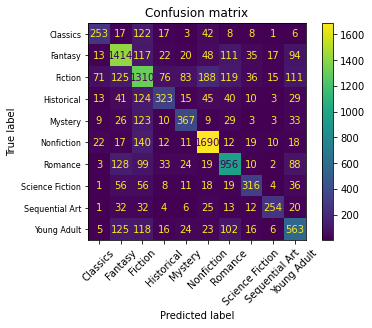

In [70]:
plot_cm(svm_pipeline, X_test, y_test)

In [51]:
svm_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=10000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(X_train_tok, y_train)
predictions = svm_pipeline.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.65      0.52      0.58       477
        Fantasy       0.71      0.75      0.73      1891
        Fiction       0.58      0.62      0.60      2134
     Historical       0.63      0.55      0.59       643
        Mystery       0.65      0.62      0.64       612
     Nonfiction       0.80      0.85      0.82      1951
        Romance       0.69      0.71      0.70      1362
Science Fiction       0.71      0.61      0.66       525
 Sequential Art       0.83      0.65      0.73       399
    Young Adult       0.59      0.56      0.57       998

       accuracy                           0.68     10992
      macro avg       0.68      0.64      0.66     10992
   weighted avg       0.68      0.68      0.68     10992

Confusion matrix:
[[ 247   18  129   15    4   50    3    6    2    3]
 [  17 1423  106   23   23   36  114   35   13  101]
 [  62  128 1315   76   85  204  107   33   11  113]

In [72]:
eval_accuracy(predictions, y_test)

0.6774017467248908

In [62]:
param_grid = [{'sel__k': [3000, 5000, 7000,'all'], 'learner__C': [0.01, 0.1, 1, 10, 100]}]

opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  
    ('tfidf', TfidfTransformer()), 
    ('learner', LinearSVC())
])

n_jobs = 5 
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, cv=10, n_jobs = n_jobs, verbose=True).fit(X_train_tok,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 200 out of 200 | elapsed:  5.5min finished


In [75]:
SVM_opt_search.best_params_


{'learner__C': 1, 'sel__k': 'all'}

In [76]:
SVM_opt_search.best_estimator_


Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x0000021912258AF0>)),
                ('tfidf', TfidfTransformer()), ('learner', LinearSVC(C=1))])

In [77]:
opt_predictions = SVM_opt_search.best_estimator_.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, opt_predictions)
print(cm)

Classification report:
                 precision    recall  f1-score   support

       Classics       0.75      0.55      0.63       477
        Fantasy       0.71      0.79      0.75      1891
        Fiction       0.60      0.67      0.63      2134
     Historical       0.67      0.50      0.57       643
        Mystery       0.68      0.64      0.66       612
     Nonfiction       0.82      0.88      0.85      1951
        Romance       0.70      0.74      0.72      1362
Science Fiction       0.79      0.60      0.68       525
 Sequential Art       0.88      0.61      0.72       399
    Young Adult       0.61      0.57      0.59       998

       accuracy                           0.70     10992
      macro avg       0.72      0.65      0.68     10992
   weighted avg       0.71      0.70      0.70     10992

Confusion matrix:
[[ 261   18  120   14    5   46    6    3    1    3]
 [  12 1489  106   18   19   32  101   20    9   85]
 [  43  126 1423   54   70  185  114   23    6   90]

In [78]:
eval_accuracy(y_test, opt_predictions)

0.6774017467248908

In [79]:
tokenizer = vect
selector = svm_pipeline.named_steps['sel']
classifier = svm_pipeline.named_steps['learner']

In [80]:
feature_names = tokenizer.get_feature_names()
feats_w_score = list()
for index,(selected,score) in enumerate(zip(selector.get_support(),selector.scores_)):
    feats_w_score.append((score,selected,feature_names[index]))
feats_w_score = sorted(feats_w_score)
len(feats_w_score)

24544

In [82]:
feats_w_score[:100]

[(0.21392045753590613, False, 'BI_darkness_inside'),
 (0.21651554443817642, False, 'BI_genetically_alter'),
 (0.2402463734867762, False, 'BI_history_legend'),
 (0.26177890325704717, False, 'BI_course_nothing'),
 (0.26947051815920886, False, 'BI_even_chance'),
 (0.27391173149810516, False, 'BI_across_vast'),
 (0.27831864047149496, False, 'BI_learn_become'),
 (0.28267527378397456, False, '27'),
 (0.2981662060272371, False, 'BI_alive_never'),
 (0.3012013230844071, False, 'BI_continue_resonate'),
 (0.30234001588275483, False, 'BI_find_girl'),
 (0.3106327574313132, False, 'BI_human_progress'),
 (0.3129516976733776, False, 'BI_ever_dream'),
 (0.3164858949211927, False, 'BI_love_wife'),
 (0.321459504620903, False, 'BI_age_ten'),
 (0.3219587911387475, False, 'BI_dan_brown'),
 (0.32442788147738766, False, 'BI_jazz_musician'),
 (0.3246146381120741, False, 'BI_book_publisher'),
 (0.3317406513990947, False, 'BI_life_relationship'),
 (0.33344562797630184, False, 'BI_last_gift'),
 (0.333629086305329

In [83]:
feats_w_score[-100:]


[(77.29243726815528, True, 'BI_faraway_land'),
 (78.11925440817465, True, 'BI_ever_expect'),
 (79.51631460556443, True, 'BI_entirely_human'),
 (80.310909386929, True, 'BI_food_writer'),
 (80.34308996042151, True, 'BI_human_achievement'),
 (80.62809453616617, True, 'BI_job_come'),
 (80.66369834000452, True, 'BI_american_debut'),
 (81.70202350682369, True, 'BI_completely_limit'),
 (82.00642080217243, True, 'BI_end_result'),
 (82.05591149835946, True, 'BI_change_rule'),
 (82.14759218228562, True, 'BI_life_run'),
 (82.37957198816609, True, 'BI_catch_family'),
 (82.71263717176377, True, 'BI_cobble_together'),
 (83.21886739942599, True, 'BI_baton_rouge'),
 (83.22053732560437, True, 'BI_escape_—'),
 (83.5735046915172, True, 'BI_ever_experience'),
 (83.65873237683692, True, 'BI_drama_life'),
 (83.74984225682837, True, 'BI_lose_land'),
 (83.86816774345091, True, 'BI_--_anything'),
 (85.57635897727161, True, 'BI_intend_take'),
 (86.34488029443779, True, 'BI_lead_lady'),
 (86.49682596785784, True

In [84]:
feats_w_classifier_weight = list()
for index,weight in enumerate(selector.inverse_transform(classifier.coef_)[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

6659

In [85]:
feats_w_classifier_weight[-100:]


[(1.1539846877847273, 'BI_love_obsession'),
 (1.154341192941239, 'BI_dragon_—'),
 (1.155174131926742, 'BI_find_deal'),
 (1.1559257619196686, 'BI_far_well'),
 (1.156953393551502, 'BI_give_much'),
 (1.1635369248225547, 'BI_erotic_romance'),
 (1.1651595175992324, 'BI_make_strong'),
 (1.1663862968898941, 'BI_man_marry'),
 (1.1666022855500793, 'BI_french_countryside'),
 (1.1668647116428434, 'BI_chance_redemption'),
 (1.1717704642601883, 'BI_fan_old'),
 (1.1749470969330067, 'BI_death_end'),
 (1.180356832242398, 'BI_loyalty_love'),
 (1.1883559635476746, 'BI_author_meg'),
 (1.1944608643217456, 'BI_fate_decide'),
 (1.205968725903568, 'BI_highly_anticipated'),
 (1.2065988808190664, 'BI_choose_family'),
 (1.2085692577460405, 'BI_manic_depression'),
 (1.2113209129737976, 'BI_heart_great'),
 (1.2157496771046452, 'BI_international_good'),
 (1.2189546316100854, 'BI_easy_well'),
 (1.2216773336461988, 'BI_life_prepare'),
 (1.223164113751533, 'BI_far_world'),
 (1.2248866861900984, 'BI_gift_make'),
 (1.2

In [86]:
feats_w_classifier_weight[100:]


[(-0.8087073026689161, 'BI_live_among'),
 (-0.8040501260350421, 'BI_broken_part'),
 (-0.8040113827827928, 'BI_connie_willis'),
 (-0.8033140809447908, 'BI_award_nominate'),
 (-0.802769475409514, 'BI_act_strangely'),
 (-0.8015847763639306, 'BI_find_kind'),
 (-0.7998054202004359, 'BI_hide_among'),
 (-0.7989844388402427, 'BI_book_also'),
 (-0.7981725335647665, 'BI_jack_reacher'),
 (-0.7981430764468092, 'BI_keep_true'),
 (-0.7967986701341998, 'BI_history_decade'),
 (-0.7966686137854919, 'BI_change_around'),
 (-0.7953695095590229, 'BI_astonishing_discovery'),
 (-0.7943145363269036, 'BI_believe_happen'),
 (-0.7939348891272567, "BI_dickens_'s"),
 (-0.7918641061595239, 'BI_fyodor_dostoevsky'),
 (-0.7911010553281898, 'BI_delight_reader'),
 (-0.7882138978212241, 'BI_control_one'),
 (-0.7876587963625931, 'BI_life_normal'),
 (-0.7858328824087887, 'BI_brianna_’s'),
 (-0.7856104791718189, 'BI_come_believe'),
 (-0.7853914226056408, 'BI_man_seem'),
 (-0.7844350922566488, '1855'),
 (-0.7842497295309916,